* [EDA](#eda)
* [Построение новых признаков](#feature)
* [Модель регрессии](#regress)
* [Оценка качества модели](#grade)
* [Значимость уравнения регрессии](#significance)
* [Статистика](#stat)
* [Вывод](#itog)

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage. (уменьшаем объем памяти, который занимает датасет)       
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
matplotlib.rcParams.update({'font.size': 8})  # размер шрифта на графиках

In [4]:
df = pd.read_csv('BankChurners.csv', encoding='cp1251', sep=',')

**EDA** - Exploratory Data Analysis<a class='anchor' id='eda'>

**Описание датасета**\
\
База данных клиентов одного из Европейских банков по кредитным картам на 19.11.2020 г.
* **CLIENTNUM** - ID клиента
* **Attrition_Flag** - Переменная внутреннего события (активности клиента) - если счет закрыт, то 1 иначе 0
* **Customer_Age** - возраст
* **Dependent_count** - Количество иждивенцев
* **Education_Level** - Демографическая переменная - Образовательная квалификация владельца счета
* **Marital_Status** - Демографическая переменная - Женат, Холост, Разведен, Неизвестен
* **Income_Category** - Демографическая переменная - Годовая категория дохода владельца счета (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, >)
* **Card_Category** - Переменная продукта - Тип карты (синий, серебристый, золотой, платиновый)
* **Months_on_book** - Период взаимоотношений с банком
* **Total_Relationship_Count** - Кол-во используемых продуктов
* **Months_Inactive_12_mon** - неактивных за последние 12 месяцев
* **Contacts_Count_12_mon** - Контактов за последние 12 месяцев
* **Credit_Limit** - Кредитный лимит по кредитной карте
* **Total_Revolving_Bal** - Общий возобновляемый остаток по кредитной карте
* **Avg_Open_To_Buy** - Открытая для покупки кредитная линия (в среднем за последние 12 месяцев)
* **Total_Amt_Chng_Q4_Q1** - Изменение суммы транзакции (Q4 по сравнению с Q1)
* **Total_Trans_Amt** - Общая сумма транзакции (за последние 12 месяцев)
* **Total_Trans_Ct** - Общее количество транзакций (за последние 12 месяцев)
* **Total_Ct_Chng_Q4_Q1** - Изменение количества транзакций (Q4 по сравнению с Q1)
* **Avg_Utilization_Ratio** - Средний коэффициент использования карт


In [5]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [6]:
# удаляю не нужные данные
df = df.drop(
    ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], 
    axis=1)
df = df.drop(
    ['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], 
    axis=1)

Типы данных в колонках:

In [7]:
df.dtypes

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

Основные статистики по данным:

In [8]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


Данные в выборке прхожи на реальные, выбросы не наблюдаются

Проверим нулевые значения для дальнейшей обработки, если такие имеются

In [9]:
df.isna().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

Нулевых значений нет. Посмотрим на гистограммы каждого показателя

array([[<AxesSubplot:title={'center':'CLIENTNUM'}>,
        <AxesSubplot:title={'center':'Customer_Age'}>,
        <AxesSubplot:title={'center':'Dependent_count'}>,
        <AxesSubplot:title={'center':'Months_on_book'}>],
       [<AxesSubplot:title={'center':'Total_Relationship_Count'}>,
        <AxesSubplot:title={'center':'Months_Inactive_12_mon'}>,
        <AxesSubplot:title={'center':'Contacts_Count_12_mon'}>,
        <AxesSubplot:title={'center':'Credit_Limit'}>],
       [<AxesSubplot:title={'center':'Total_Revolving_Bal'}>,
        <AxesSubplot:title={'center':'Avg_Open_To_Buy'}>,
        <AxesSubplot:title={'center':'Total_Amt_Chng_Q4_Q1'}>,
        <AxesSubplot:title={'center':'Total_Trans_Amt'}>],
       [<AxesSubplot:title={'center':'Total_Trans_Ct'}>,
        <AxesSubplot:title={'center':'Total_Ct_Chng_Q4_Q1'}>,
        <AxesSubplot:title={'center':'Avg_Utilization_Ratio'}>,
        <AxesSubplot:>]], dtype=object)

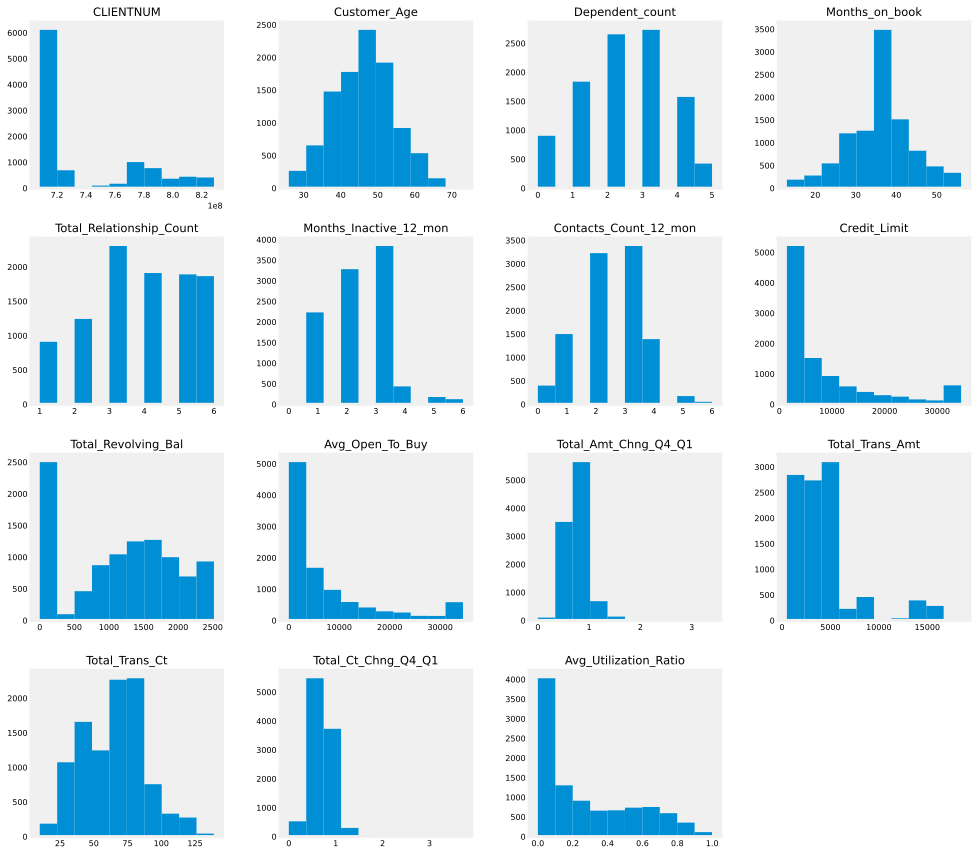

In [10]:
df.hist(figsize=(15,15), bins=10, grid=False)

По данным графиков, можем сделать следующие выводы:
* Большинство заемщиков в возрасте 46 лет
* В основном у заемщиков 2-3 иждевенца
* по 3 и более продукта в основном пользуются заемщики
* Большинство заемщиков в банке обслуживаются 36 мес.
* Большое кол-во заемщиков не полььзуются продуктами в общей сложности в течении 3-х месяцев на протяжении года.


In [11]:
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


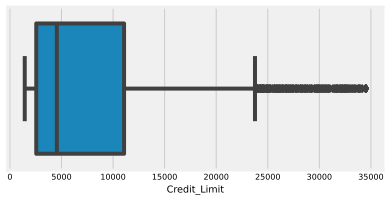

In [12]:
plt.figure(figsize=(6, 3))

sns.boxplot(df['Credit_Limit'], whis=1.5)

plt.xlabel('Credit_Limit')
plt.show()

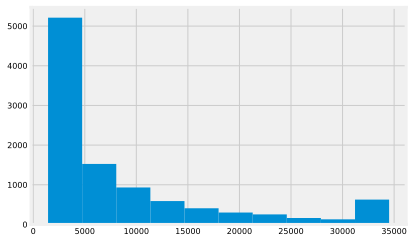

In [13]:
df['Credit_Limit'].hist();

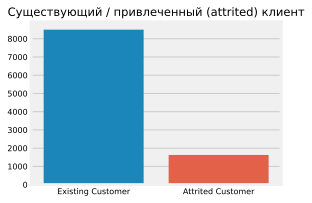

In [14]:
counts = df['Attrition_Flag'].value_counts()
    
plt.figure(figsize=(4,3))    
plt.title('Существующий / привлеченный (attrited) клиент')
sns.barplot(counts.index, counts.values)
    
plt.show()

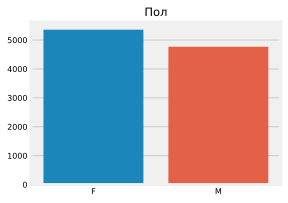

In [15]:
counts = df['Gender'].value_counts()
    
plt.figure(figsize=(4,3))    
plt.title('Пол')
sns.barplot(counts.index, counts.values)
    
plt.show()

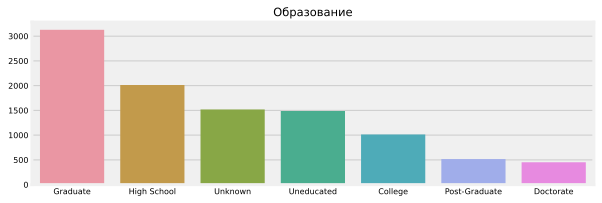

In [16]:
counts = df['Education_Level'].value_counts()
    
plt.figure(figsize=(9,3))    
plt.title('Образование')
sns.barplot(counts.index, counts.values)
    
plt.show()

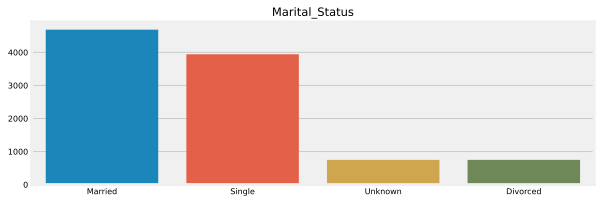

In [17]:
counts = df['Marital_Status'].value_counts()
    
plt.figure(figsize=(9,3))    
plt.title('Marital_Status')
sns.barplot(counts.index, counts.values)
    
plt.show()

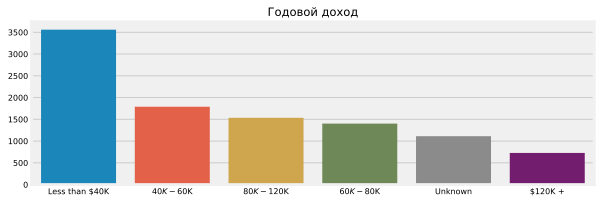

In [18]:
counts = df['Income_Category'].value_counts()
    
plt.figure(figsize=(9,3))    
plt.title('Годовой доход')
sns.barplot(counts.index, counts.values)
    
plt.show()

построение новых фич

In [19]:
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


### 2. Построение новых признаков  <a class='anchor' id='feature'>

In [20]:
def salary_cat(X):

    X['salary_cat'] = 0

    X.loc[X['Income_Category'] == 'Unknown', 'salary_cat'] = 0  
    X.loc[X['Income_Category'] == 'Less than $40K', 'salary_cat'] = 1
    X.loc[X['Income_Category'] == '40𝐾− 60K', 'salary_cat'] = 2
    X.loc[X['Income_Category'] == '60𝐾− 80K', 'salary_cat'] = 3
    X.loc[X['Income_Category'] == '80𝐾− 120K', 'salary_cat'] = 4
    X.loc[X['Income_Category'] == '$120K +', 'salary_cat'] = 5
    
    return X

def status_cat(X):

    X['status_cat'] = 0

    X.loc[X['Marital_Status'] == 'Unknown', 'status_cat'] = 0  
    X.loc[X['Marital_Status'] == 'Single', 'status_cat'] = 1
    X.loc[X['Marital_Status'] == 'Married', 'status_cat'] = 2
    X.loc[X['Marital_Status'] == 'Divorced', 'status_cat'] = 3
    
    return X

def gender_cat(X):

    X['gender_cat'] = 0

    X.loc[X['Gender'] == 'F', 'gender_cat'] = 1  
    X.loc[X['Gender'] == 'M', 'gender_cat'] = 2
    
    return X

def education_cat(X):

    X['education_cat'] = 0

    X.loc[X['Education_Level'] == 'Unknown', 'education_cat'] = 0  
    X.loc[X['Education_Level'] == 'Uneducated', 'education_cat'] = 1
    X.loc[X['Education_Level'] == 'High School', 'education_cat'] = 2  
    X.loc[X['Education_Level'] == 'College', 'education_cat'] = 3
    X.loc[X['Education_Level'] == 'Graduate', 'education_cat'] = 4  
    X.loc[X['Education_Level'] == 'Post-Graduate', 'education_cat'] = 5
    X.loc[X['Education_Level'] == 'Doctorate', 'education_cat'] = 6
    
    return X

In [21]:
df = salary_cat(df)
df = status_cat(df)
df = gender_cat(df)
df = education_cat(df)

In [22]:
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,salary_cat,status_cat,gender_cat,education_cat
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0,2,2,2
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,1,1,1,4
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0,2,2,4
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,1,0,1,2
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0,1,2,4
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0,3,2,0
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,1,2,1,2
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0,0,2,4


*Посмотрим на матрицу корреляций*

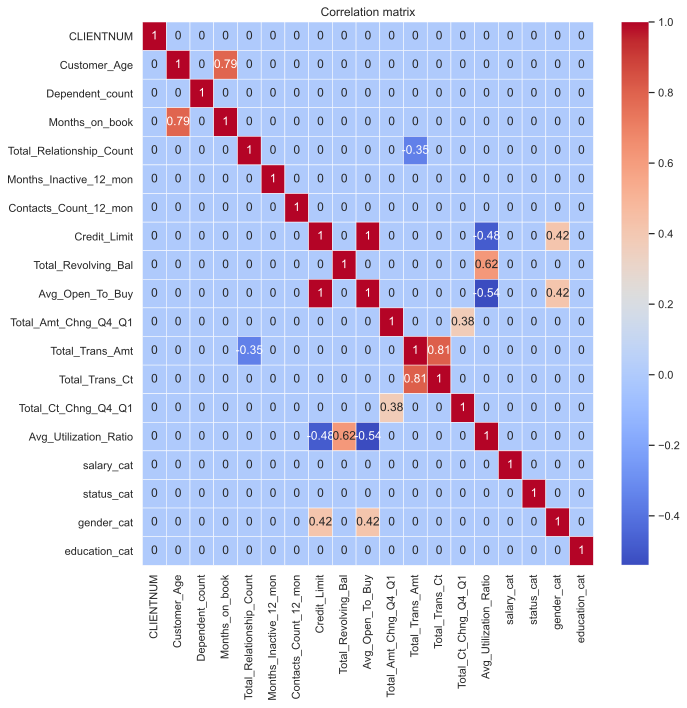

In [23]:
plt.figure(figsize = (9,10))

sns.set(font_scale=1)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

*Видим, что возраст заемщика и период взаимоотношений с банком коррелируют друг с другом. Сумма транзакций и колличество транзакций также влияют друг на друга. Интересно, что кредитный лимит и пол заемщика влияют друг на друга*

* **CLIENTNUM** - ID клиента
* **Attrition_Flag** - Переменная внутреннего события (активности клиента) - если счет закрыт, то 1 иначе 0
* **Customer_Age** - возраст
* **Dependent_count** - Количество иждивенцев
* **Education_Level** - Демографическая переменная - Образовательная квалификация владельца счета
* **Marital_Status** - Демографическая переменная - Женат, Холост, Разведен, Неизвестен
* **Income_Category** - Демографическая переменная - Годовая категория дохода владельца счета (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, >)
* **Card_Category** - Переменная продукта - Тип карты (синий, серебристый, золотой, платиновый)
* **Months_on_book** - Период взаимоотношений с банком
* **Total_Relationship_Count** - Кол-во используемых продуктов
* **Months_Inactive_12_mon** - неактивных за последние 12 месяцев
* **Contacts_Count_12_mon** - Контактов за последние 12 месяцев
* **Credit_Limit** - Кредитный лимит по кредитной карте
* **Total_Revolving_Bal** - Общий возобновляемый остаток по кредитной карте
* **Avg_Open_To_Buy** - Открытая для покупки кредитная линия (в среднем за последние 12 месяцев)
* **Total_Amt_Chng_Q4_Q1** - Изменение суммы транзакции (Q4 по сравнению с Q1)
* **Total_Trans_Amt** - Общая сумма транзакции (за последние 12 месяцев)
* **Total_Trans_Ct** - Общее количество транзакций (за последние 12 месяцев)
* **Total_Ct_Chng_Q4_Q1** - Изменение количества транзакций (Q4 по сравнению с Q1)
* **Avg_Utilization_Ratio** - Средний коэффициент использования карт


### 3. Модель регрессии <a class='anchor' id='regress'>

*Построим модель регрессии, которая будет предсказывать остаток по кредитной карте по его сумме транзакций за послдение 12 мес. и по  Открытой для покупки кредитной линий (в среднем за последние 12 месяцев)*

In [24]:
y = df['Total_Revolving_Bal'].values
X = df[['Total_Trans_Amt', 'Avg_Open_To_Buy']].values 

In [25]:
y.shape, X.shape

((10127,), (10127, 2))

*Добавим к матрице столбец из 1*

In [26]:
ones = np.ones((X.shape[0], 1))
X = np.hstack((ones, X))
X.shape

(10127, 3)

*Запишем матрицу $Х^тХ$ и посчитаем ее определитель*

In [27]:
XTX = X.T.dot(X)
np.linalg.det(XTX)

9.63052647205308e+26

*определитель очень далек от нуля, значит обратая матрица не будет стемиться к бесконечности, значит формула отработает хорошо*

*найдем обратную матрицу*

In [28]:
XTX_inv = np.linalg.inv(XTX)
b = XTX_inv.dot(X.T).dot(y)
b

array([ 1.12420671e+03,  1.78106409e-02, -5.33290982e-03])

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
model = LinearRegression().fit(X, y)
model.intercept_, model.coef_

(1124.2067097572428, array([ 0.        ,  0.01781064, -0.00533291]))

*модель регресии имеет следующий вид: $y = 1124 + 0.017 * x1 - 0.0053 * x2$*

*Таким образом остаток по кредитной карте увеличится на 0,017 долларов, если Общая сумма транзакции увеличится на единицу, а при увеличении Открытой для покупки кредитной линии на 1 доллар остаток по кредитной карте уменьшится на 0,0053 $*

#### 4. Оценка качества модели<a class='anchor' id='grade'>

*Произведем оценку качества модели*

In [31]:
def sum_of_squares(x):
    return((x - x.mean())**2).sum()

In [32]:
z = X.dot(b)
R_2 = 1 - ((y - z)**2).sum() / sum_of_squares(X)
R_2

0.9946132777171913

#### 5. Значимость уравнения регрессии<a class='anchor' id='significance'>

*Проверим значимость уравнения регрессии. Буду использовать F-тест Фишера, который проверяет нулевую гипотезу о незначимости коэффициента детерминации R_2*

In [33]:
n = X.shape[0]
m = X.shape[1] - 1
k1 = m
k2 = n - m - 1
k1, k2

(2, 10124)

In [34]:
alpha = 0.05
t = stats.f.ppf(1-alpha, k1, k2)
t

2.996618897662762

*Критическая область от 2,99 до бесконечности. Найдем статистику*

#### 6. Статистика<a class='anchor' id='stat'>

In [35]:
F = (R_2 / k1) / ((1- R_2) / k2)
F

934656.0203915463

#### 7. Вывод<a class='anchor' id='itog'>

*Значение статистики попало в критическую область, значит гипотеза отвергается, что говорит о значимости нашего уравнения, коэффициент детерминации объясняет 99,46%. Это означает, что наша модель имеет хорошую объясняющую способность.*